In [1]:
import sys
sys.path.append('../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.plot.plot_results import CostX, CostY
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set

In [2]:
_time_intervals = 30  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 12  # Number of execution scenarios                     (chi)

M = 1e3  # Big M

init = [1]

loc1_varying_factor = pandas.DataFrame(data={'com1_pur': [1.0, 0.6, 0.25, 0.13, 0.17, 0.57, 0.72, 0.49, 0.21, 0.3, 0.59, 0.69]})

loc6_varying_factor = pandas.DataFrame(data={'com1_pur': [1.0, 0.36, 0.68, 0.28, 0.41, 0.15, 0.15, 0.68, 0.73, 0.54, 0.19, 0.13]})

# Define temporal scales
scales = TemporalScale(discretization_list=[1, _exec_scenarios, _time_intervals])

demand_factor = [1]*_exec_scenarios

In [3]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================

com1_pur = Resource(name='com1_pur', cons_max=150, block={'imp': 1, 'urg': 1}, price=0.00,
                    label='Commodity 1 consumed from outside the system', varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])

com1_in = Resource(name='com1_in', label='Commodity 1 received')

com1_stored10 = Resource(name='com1_stored10', store_max=10, label='Commodity 1 in storage10')
com1_stored20 = Resource(name='com1_stored20', store_max=20, label='Commodity 1 in storage20')
com1_stored50 = Resource(name='com1_stored50', store_max=50, label='Commodity 1 in storage50')

com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [4]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_procure = Process(name='procure com1', prod_max=150, conversion={com1_pur: -1, com1_in: 1}, capex=0.1, vopex=0.1, fopex=0.1,
                  label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=M, conversion={com1_out: -1, com1_sold: 1}, capex=0.1, vopex=0.1, fopex=0.1,
                  label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=125, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=125, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=125, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=125, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Commodity 1 received from location 4')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=125, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=125, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=125, conversion={com1_in:-1, com1_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', conversion={com1_in:-1, com1_stored10:1}, prod_max=125, capex=100, vopex=1, store_min=0.01,
                  label="Storage capacity of 10 units")
com1_discharge10 = Process(name='com1_discharge10', conversion={com1_stored10:-1, com1_out:1},  prod_max=125,
                                 label='Discharge process from storage')

com1_store20 = Process(name='com1_store20', conversion={com1_in:-1, com1_stored20:1}, prod_max=125, capex=125, vopex=2, store_min=0.01,
                  label="Storage capacity of 20 units")
com1_discharge20 = Process(name='com1_discharge20', conversion={com1_stored20:-1, com1_out:1}, prod_max=125,
                                 label='Discharge process from storage')

com1_store50 = Process(name='com1_store50', conversion={com1_in:-1, com1_stored50:1}, prod_max=125, capex=500, vopex=5, store_min=0.01,
                  label="Storage capacity of 50 units")
com1_discharge50 = Process(name='com1_discharge50', conversion={com1_stored50:-1, com1_out:1}, prod_max=125,
                                 label='Discharge process from storage')

com1_loc1_send = Process(name='com1_loc1_send', prod_max=125, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=125, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Send commodity one from location 1')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=125, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Send commodity one from location 1')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=125, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Send commodity one from location 1')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=125, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Send commodity one from location 1')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=125, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.1, vopex=0.1, fopex=0.1,
                            label='Send commodity one from location 1')


In [5]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_process, com1_store20, com1_discharge20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1, availability_factor={com1_pur: loc1_varying_factor[['com1_pur']]})

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_process, com1_store20, com1_discharge20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_process, com1_store20, com1_discharge20, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_process, com1_store50, com1_discharge50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_discharge50, com1_sell,}, label="Location 5", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc6 = Location(name='loc6', processes={com1_procure, com1_process, com1_store10, com1_discharge10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1, availability_factor={com1_pur: loc6_varying_factor[['com1_pur']]})

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_process, com1_store20, com1_discharge20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

In [6]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================
truck20_34 = Transport(name='truck20_34', resources={com1_loc3_out}, trans_max=20, label='Truck with maximum capacity of 20 units', capex=20, vopex=0.02, trans_min=0.01)
truck30_13 = Transport(name='truck30_13', resources={com1_loc1_out}, trans_max=30, label='Truck with maximum capacity of 30 units', capex=30, vopex=0.03, trans_min=0.01)
truck30_25 = Transport(name='truck30_25', resources={com1_loc2_out}, trans_max=30, label='Truck with maximum capacity of 30 units', capex=30, vopex=0.03, trans_min=0.01)
truck40_47 = Transport(name='truck40_47', resources={com1_loc4_out}, trans_max=40, label='Truck with maximum capacity of 40 units', capex=40, vopex=0.04, trans_min=0.01)
truck40_75 = Transport(name='truck40_75', resources={com1_loc7_out}, trans_max=40, label='Truck with maximum capacity of 40 units', capex=40, vopex=0.04, trans_min=0.01)
truck50_12 = Transport(name='truck50_12', resources={com1_loc1_out}, trans_max=50, label='Truck with maximum capacity of 50 units', capex=50, vopex=0.05, trans_min=0.01)
truck50_24 = Transport(name='truck50_24', resources={com1_loc2_out}, trans_max=50, label='Truck with maximum capacity of 50 units', capex=50, vopex=0.05, trans_min=0.01)
truck50_64 = Transport(name='truck50_64', resources={com1_loc6_out}, trans_max=50, label='Truck with maximum capacity of 50 units', capex=50, vopex=0.05, trans_min=0.01)
truck100_45 = Transport(name='truck100_45', resources={com1_loc4_out}, trans_max=100, label='Truck with maximum capacity of 100 units', capex=100, vopex=0.1, trans_min=0.01)

In [7]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================
transport_matrix = [
    [[], [truck50_12], [truck30_13], [], [], [], []],  # source: location 1
    [[], [], [], [truck50_24], [truck30_25], [], []],  # source: location 2
    [[], [], [], [truck20_34], [], [], []],  # source: location 3
    [[], [], [], [], [truck100_45], [], [truck40_47]],  # source: location 4
    [[], [], [], [], [], [], []],  # source: location 5
    [[], [], [], [truck50_64], [], [], []],  # source: location 6
    [[], [], [], [], [truck40_75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)

In [8]:
demand_dict = {i: {com1_sold: 100} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: 125} if i == loc5 else {com1_sold: 0} for i in locset}
min_demand_satisfaction = 0.20
min_demand_dict = {i: {com1_sold: min_demand_satisfaction*100} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_disruption = Scenario(name='scenario_disruption', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1,
                    network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='scenario_disruption')

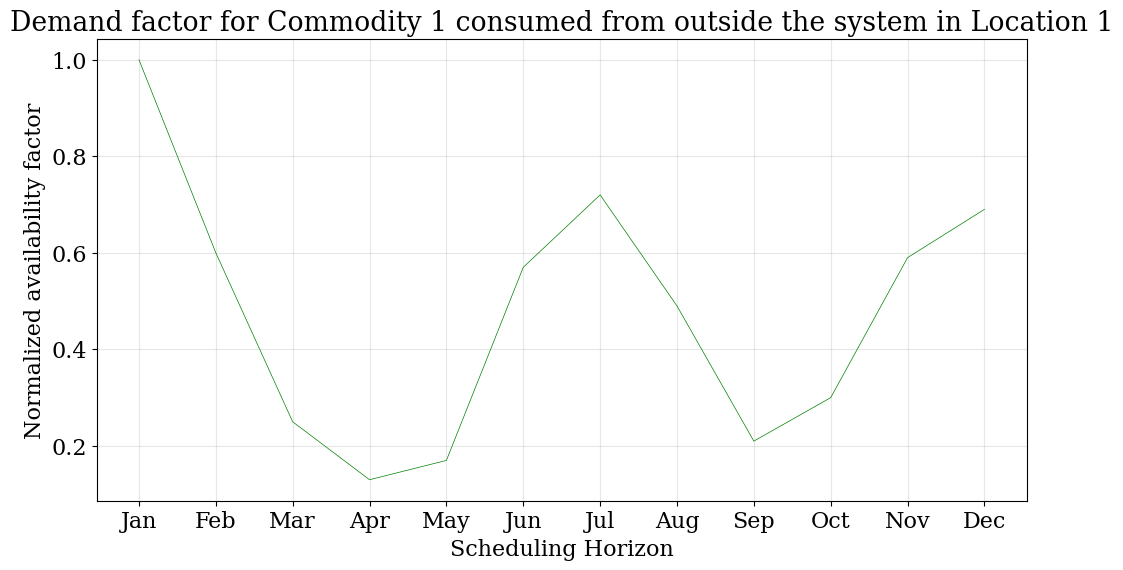

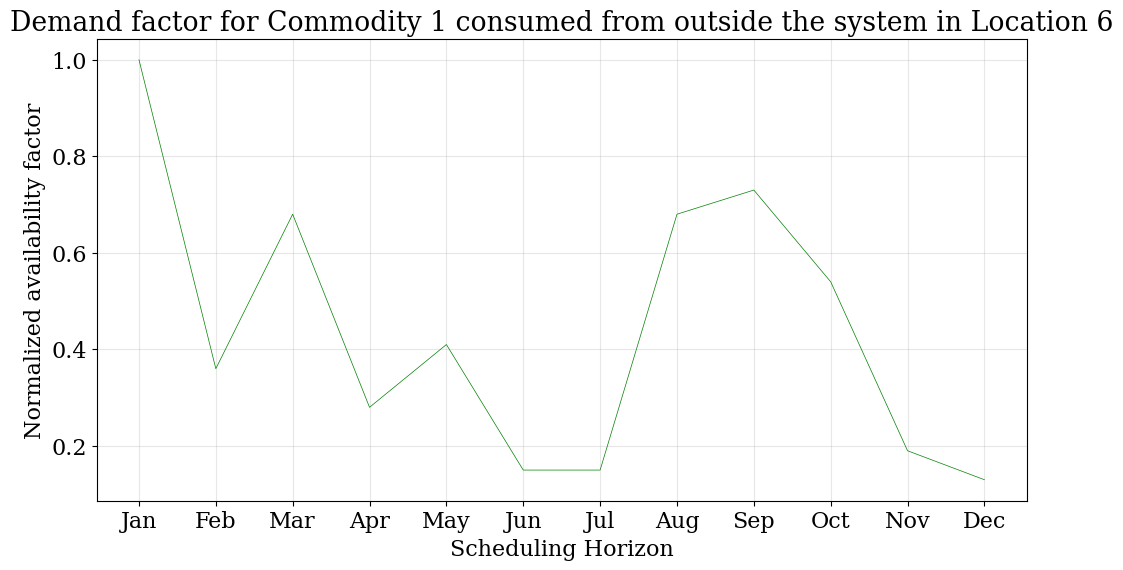

In [9]:
plot_scenario.availability_factor(scenario=scenario_disruption, resource=com1_pur, location=loc1, color='green')
plot_scenario.availability_factor(scenario=scenario_disruption, resource=com1_pur, location=loc6, color='green')

In [10]:
problem_mincost = formulate(scenario=scenario_disruption,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.NETWORK, Constraints.RESOURCE_BALANCE,
                                         Constraints.INVENTORY, Constraints.PRODUCTION,  Constraints.DEMAND},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand penalty
objective cost w demand penalty


In [11]:
# min_demand = min_demand_dict
# if isinstance(min_demand, dict):
#     if isinstance(list(min_demand.keys())[0], Location):
#         try:
#             min_demand = {i.name: {
#                 j.name: min_demand[i][j] for j in min_demand[i].keys()} for i in min_demand.keys()}
#         except:
#             pass
# 
# problem_mincost.del_component(constraint_demand2)
# problem_mincost.constraint_demand2 = constraint_demand2(instance=problem_mincost, demand=min_demand, demand_factor=scenario_disruption.demand_factor, demand_scale_level=scenario_disruption.demand_scale_level, scheduling_scale_level=scenario_disruption.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')

In [12]:
results_mincost = solve(scenario=scenario_disruption, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 422991 rows, 1346975 columns and 684356 nonzeros
Model fingerprint: 0x43292eed
Variable types: 1346366 continuous, 609 integer (609 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+04]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+03]
Found heuristic solution: objective 4500000.0000
Presolve removed 402157 rows and 1334029 columns
Presolve time: 0.53s
Presolved: 20834 rows, 12946 columns, 57502 nonzeros
Variable types: 12937 continuous, 9 integer (9 binary)

Root relaxation: objective 2.366738e+06, 19837 iterations, 1.22 seconds (1.46 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     

In [13]:
sum(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

32365.0

In [14]:
sum(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/36000

0.8990277777777778

In [15]:
min(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

61.5

In [16]:
results_mincost.output['objective']-sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')*125

1912362.9666666659

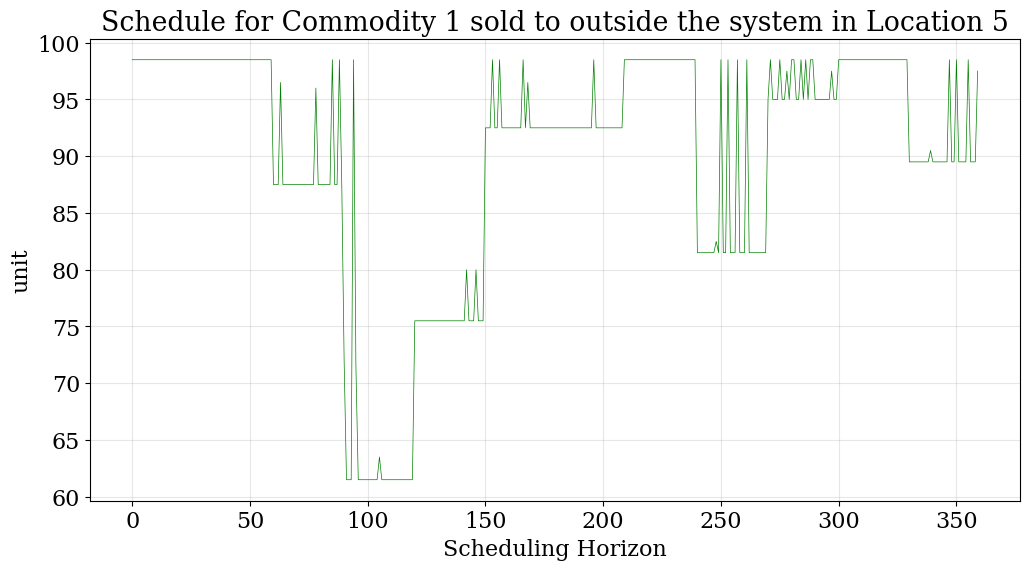

In [17]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

In [18]:
sum(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/36000


0.8990277777777778

In [19]:
min(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')


61.5

In [20]:
max(value for key, value in results_mincost.output['C'].items() if key[0]=='loc1' and key[1]=='com1_pur')*0.5/150

0.2338888888888889

In [21]:
max(value for key, value in results_mincost.output['C'].items() if key[0]=='loc6' and key[1]=='com1_pur')*0.5/150

0.16777777777777778

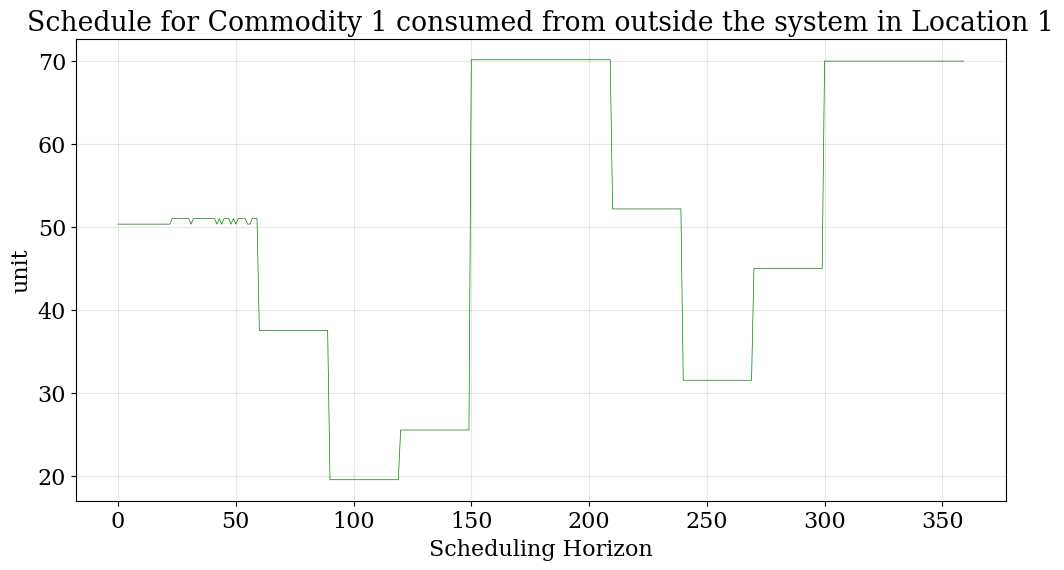

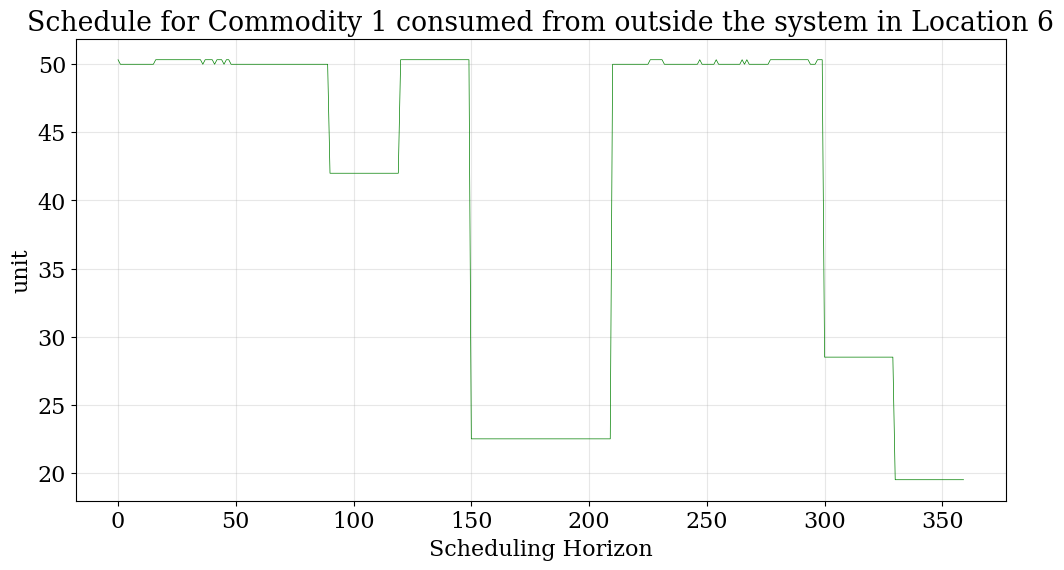

In [22]:
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc6', color='green')

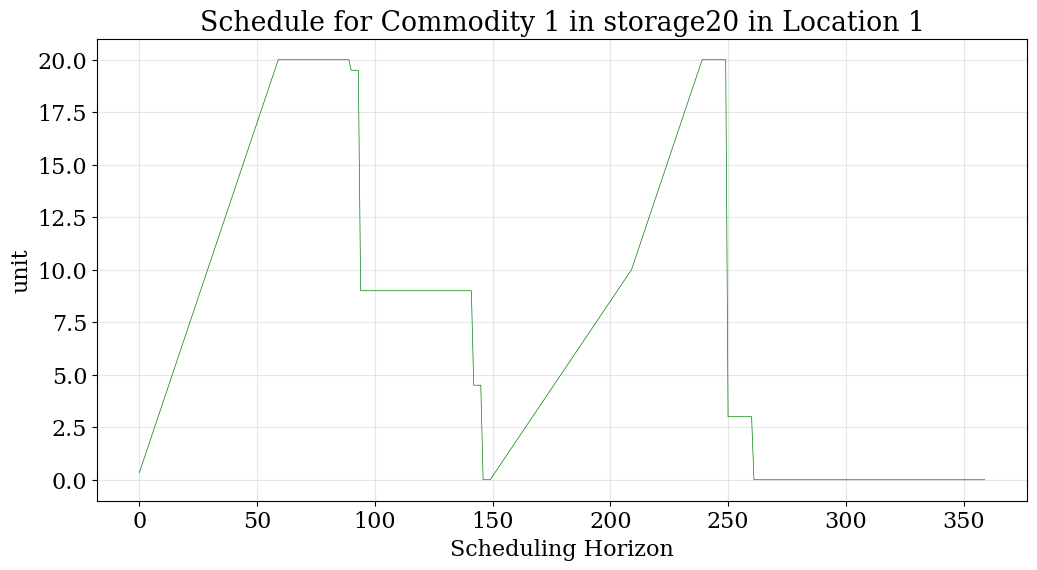

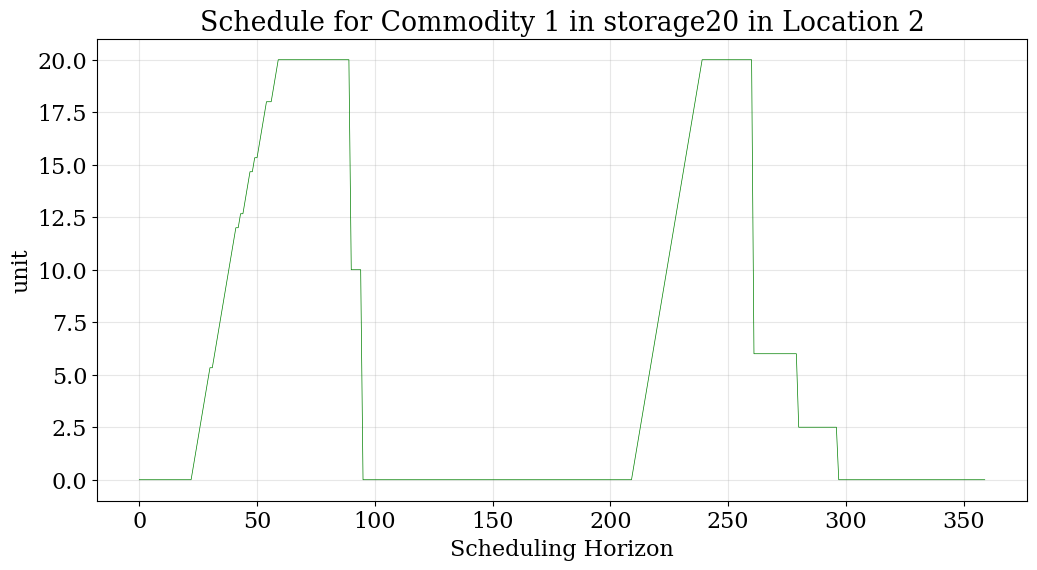

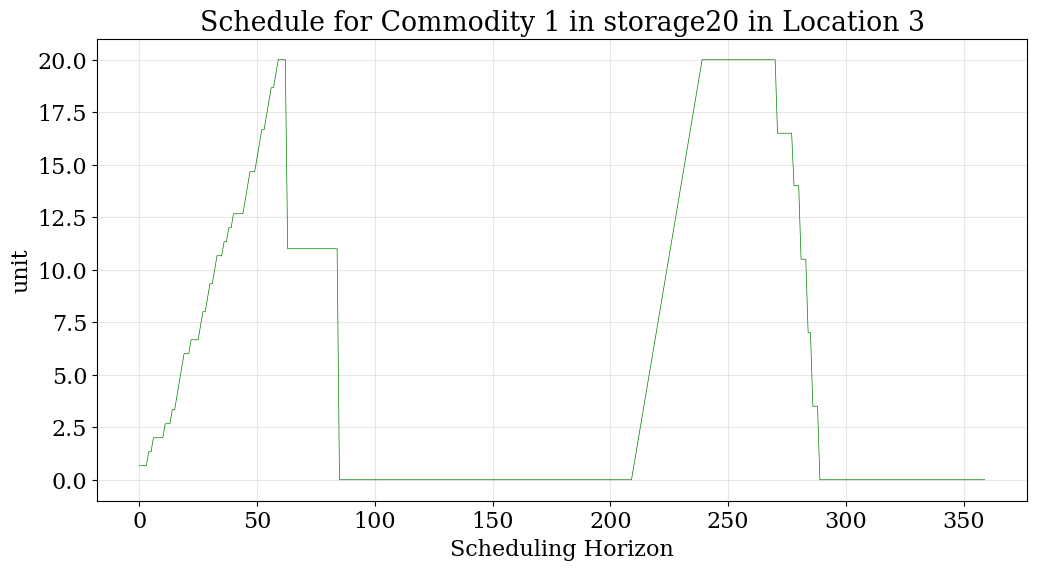

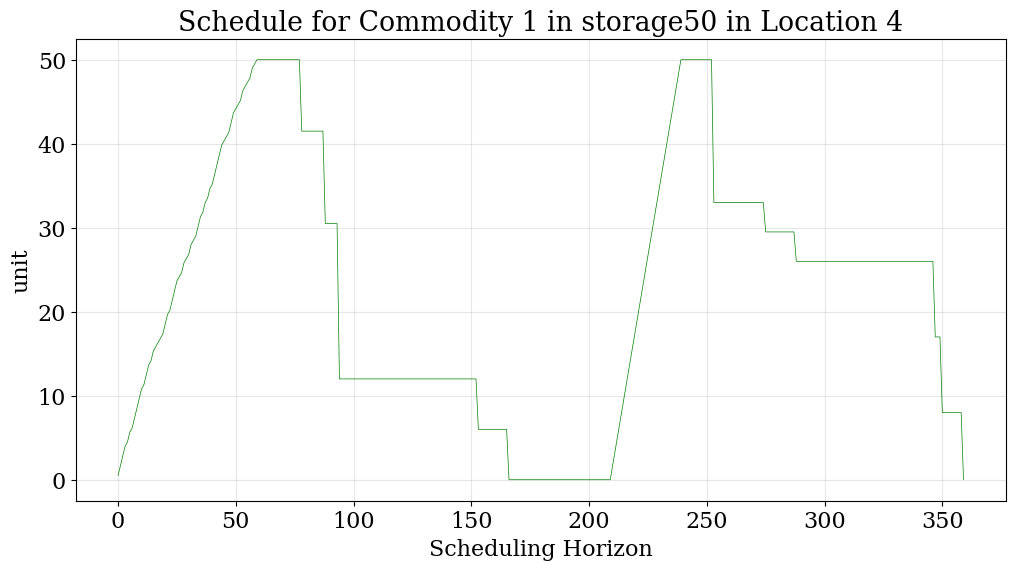

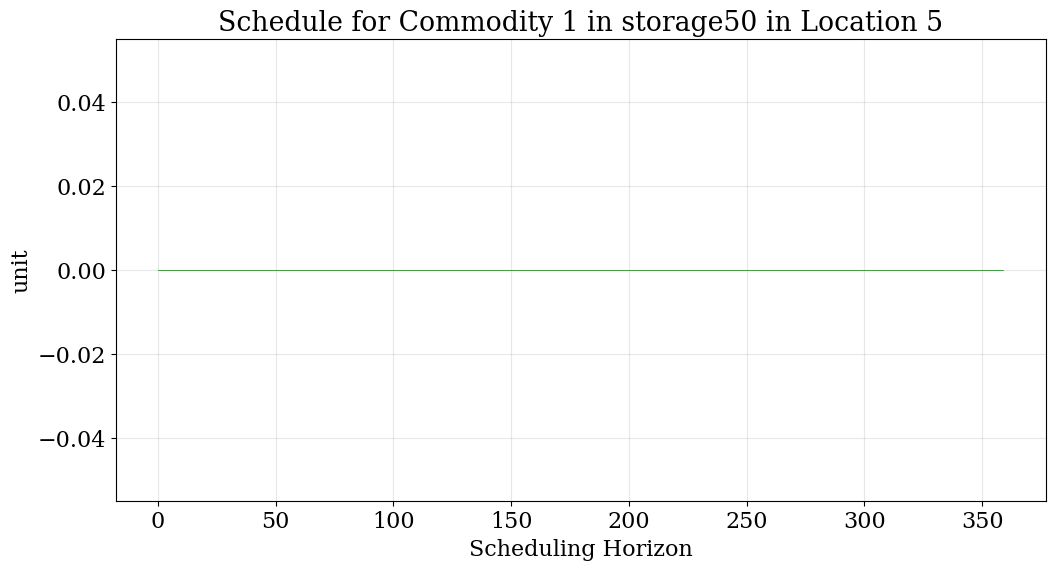

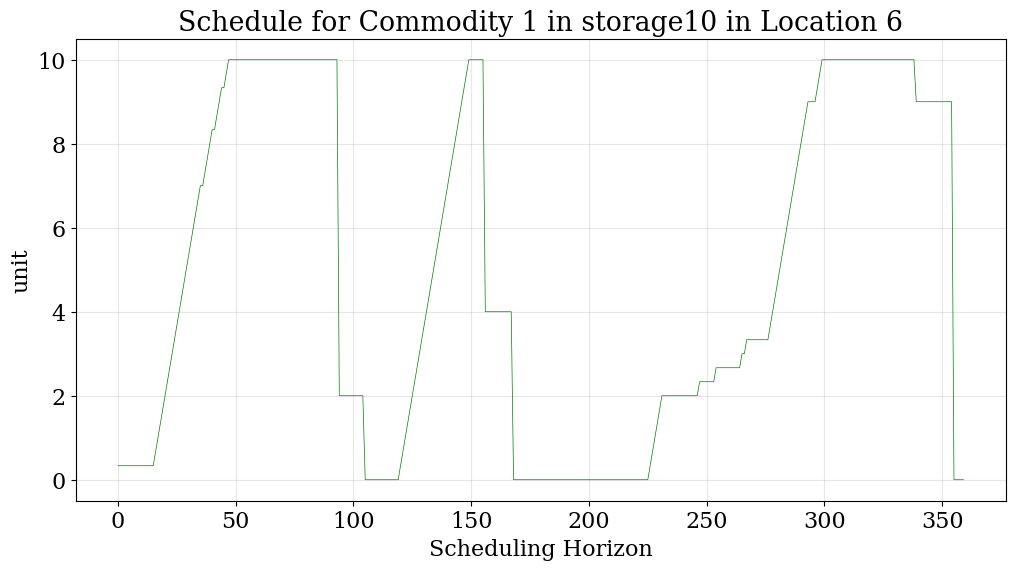

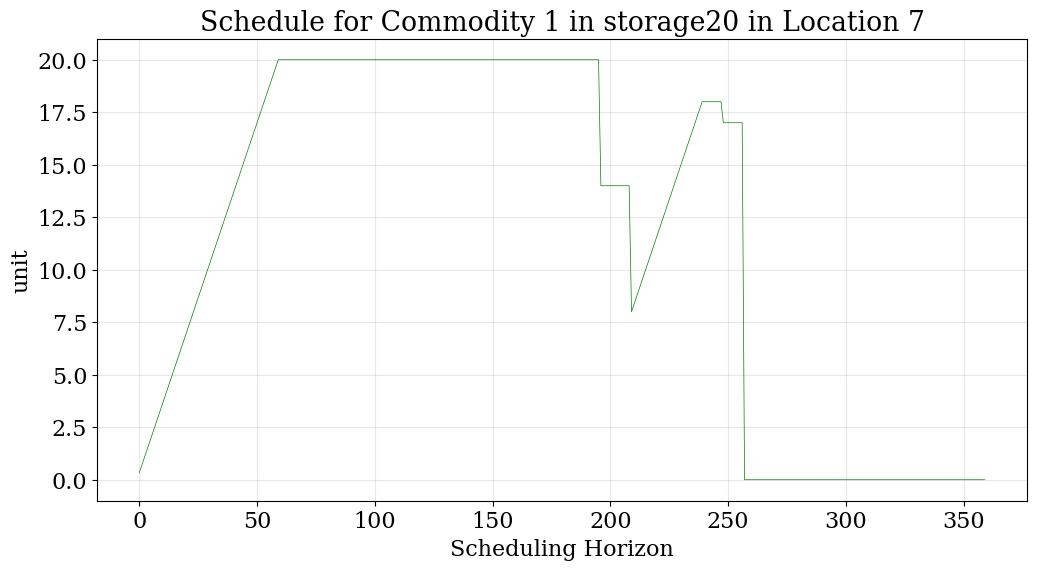

In [23]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored50', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored50', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored10', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc7', color='green')

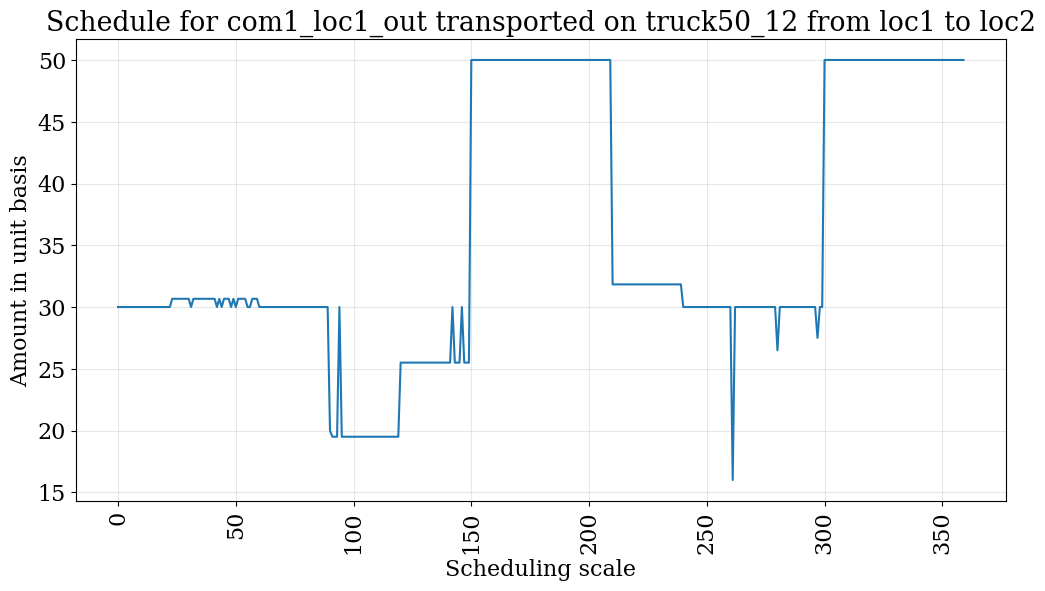

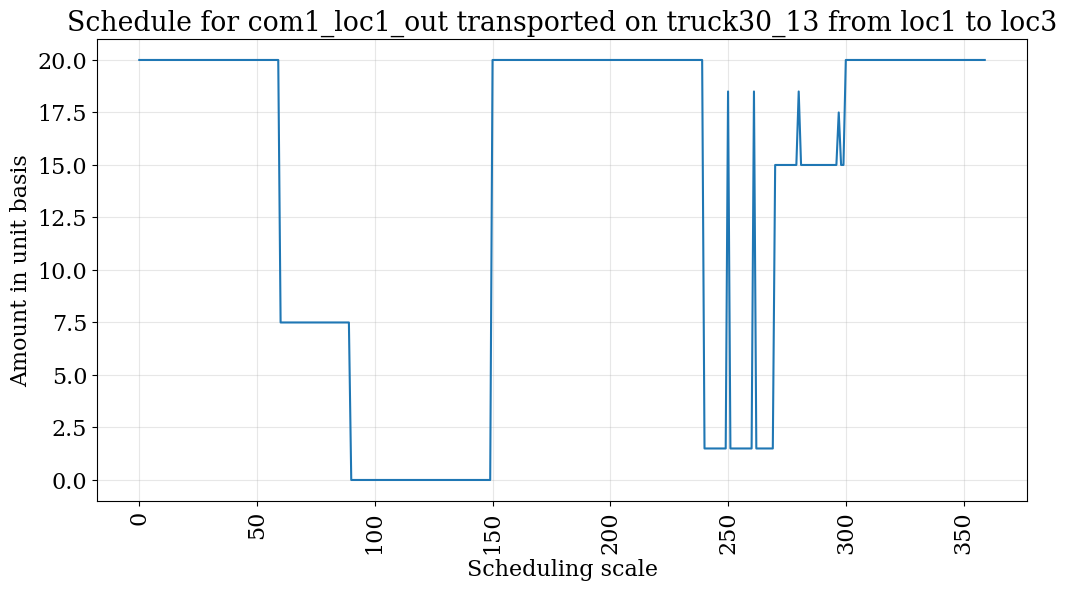

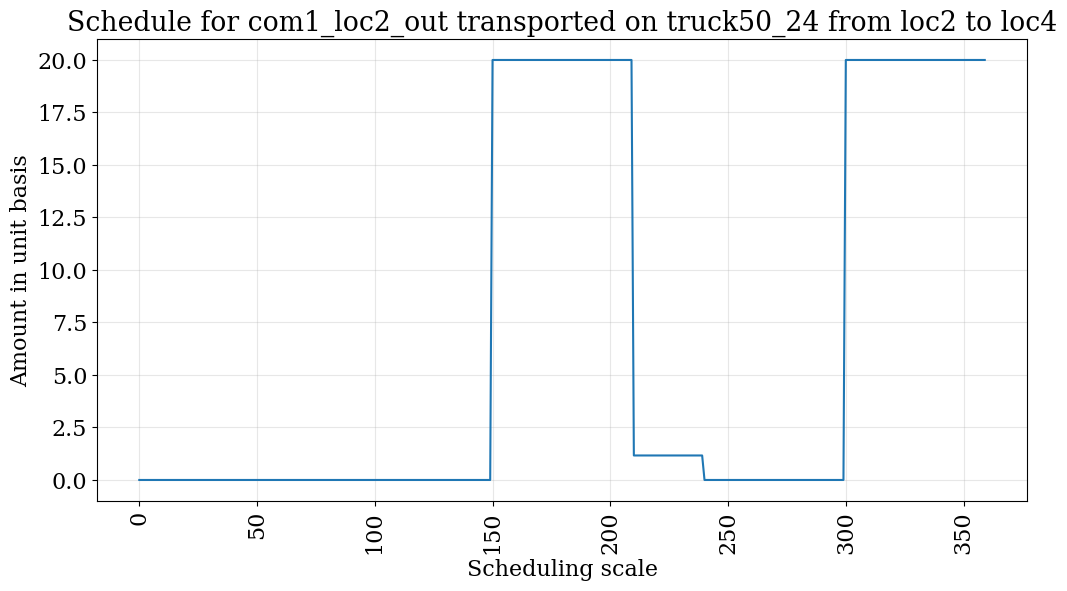

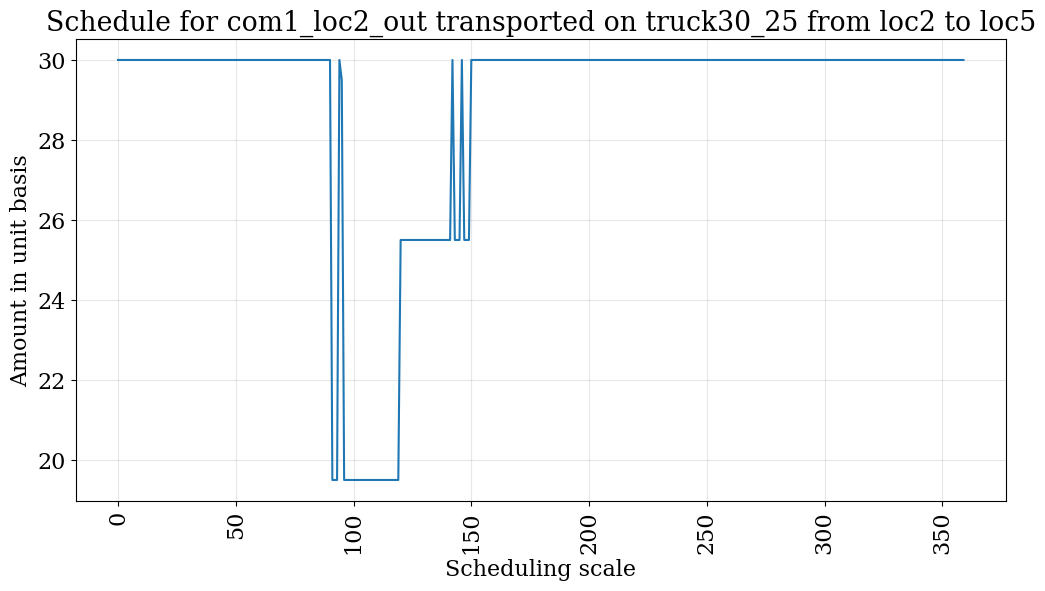

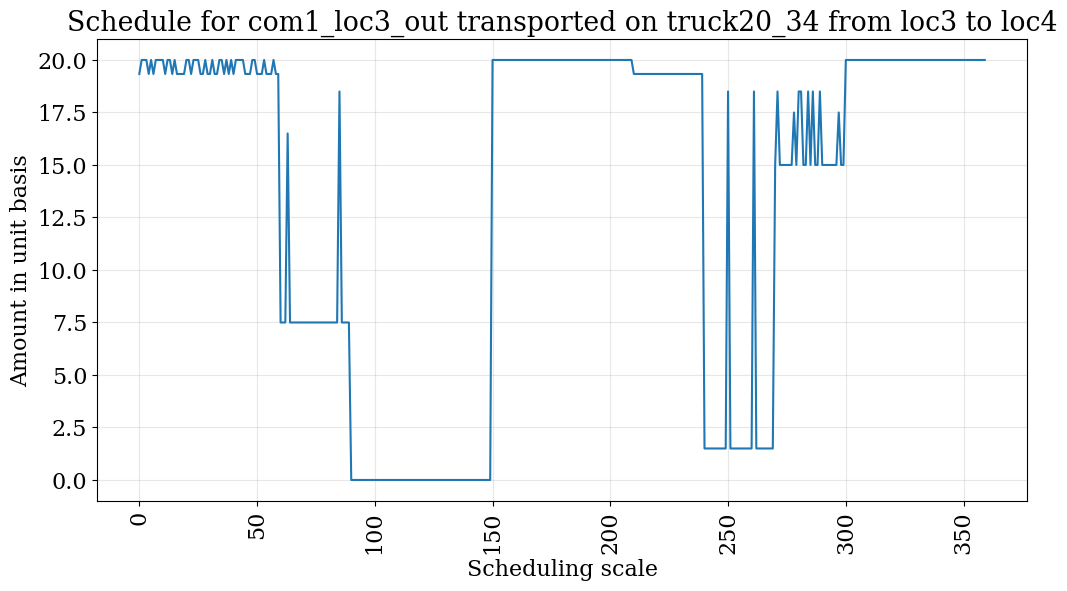

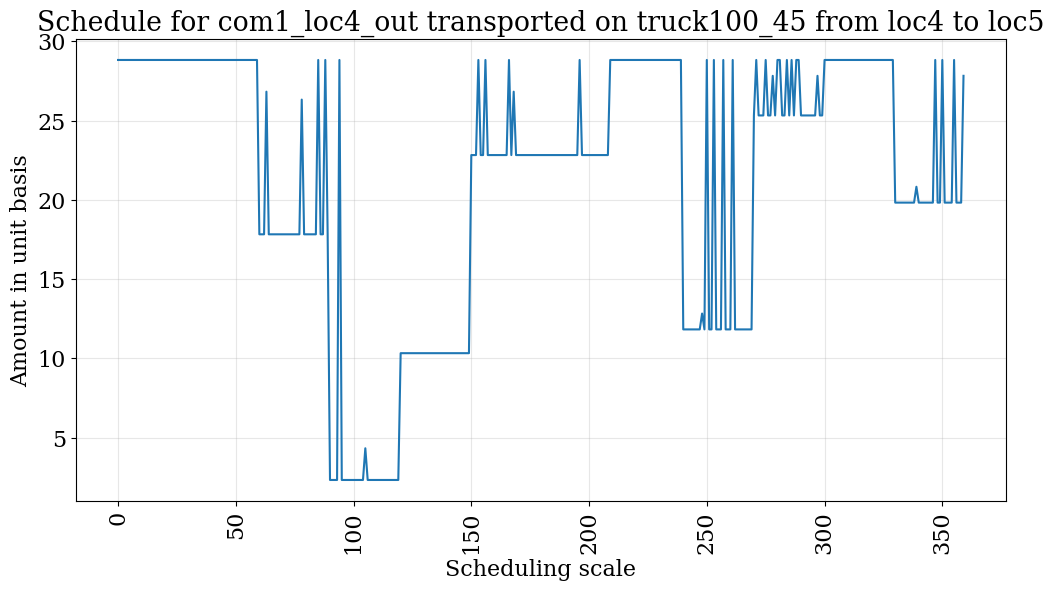

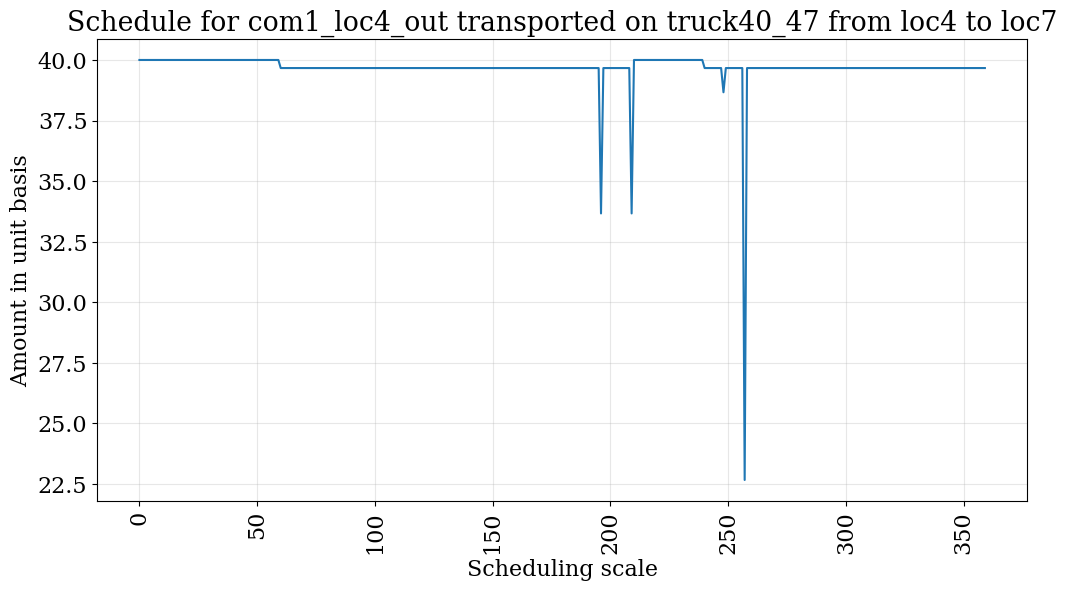

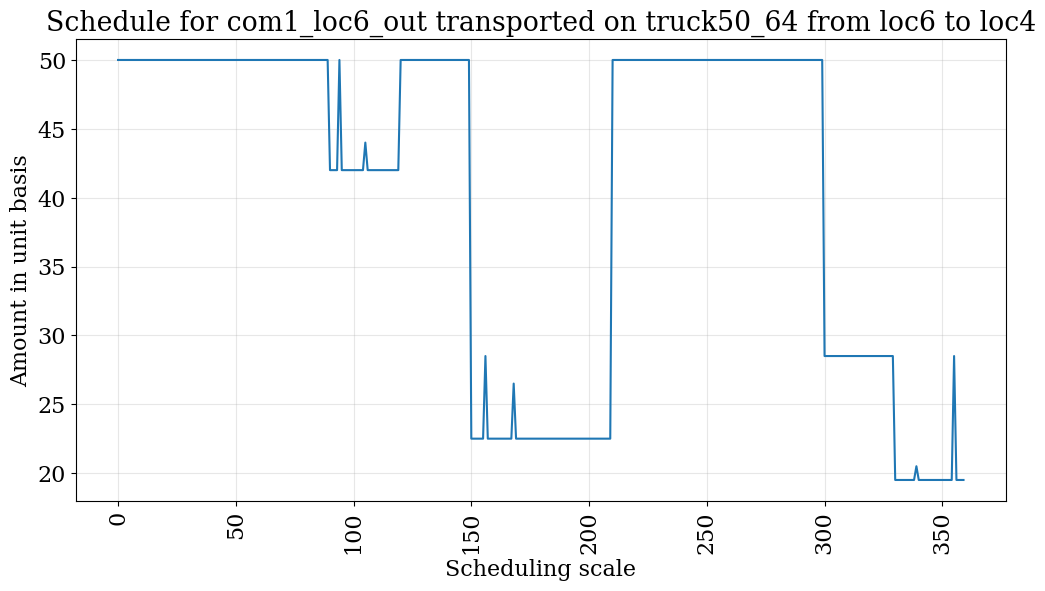

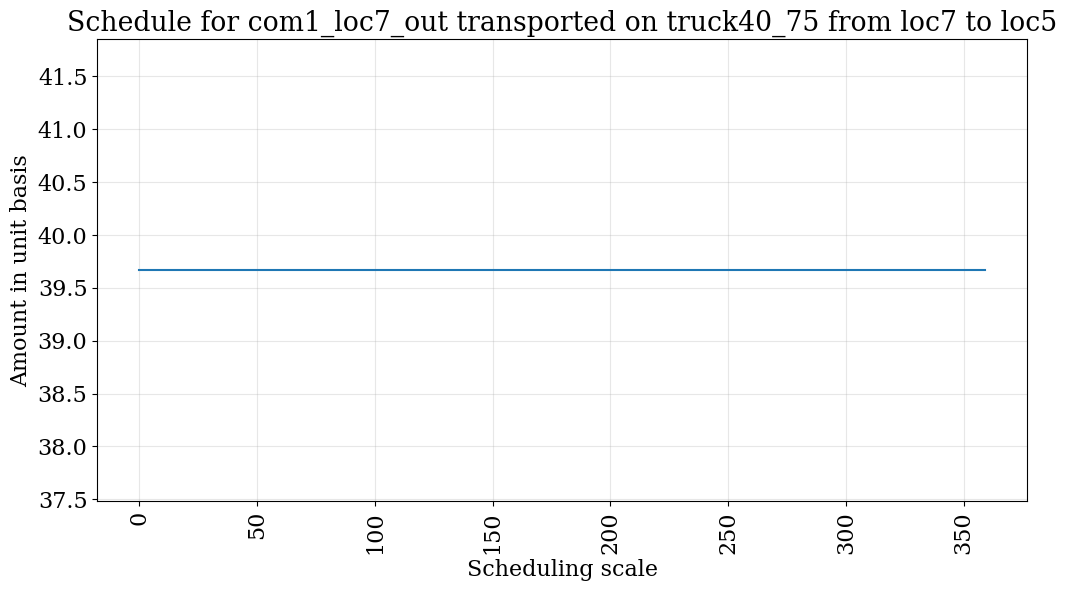

In [24]:
plot_results.transport(results=results_mincost, source='loc1', sink='loc2', transport='truck50_12',
                       resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc1', sink='loc3', transport='truck30_13',
                       resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc4', transport='truck50_24',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc5', transport='truck30_25',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc3', sink='loc4', transport='truck20_34',
                       resource='com1_loc3_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100_45',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc7', transport='truck40_47',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc6', sink='loc4', transport='truck50_64',
                       resource='com1_loc6_out')
plot_results.transport(results=results_mincost, source='loc7', sink='loc5', transport='truck40_75',
                       resource='com1_loc7_out')

In [25]:
max(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4'and key[1]=='loc5' and key[2]=='truck100_45' and key[3]=='com1_loc4_out')*0.5/100

0.14416666666666667

In [26]:
max(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7'and key[1]=='loc5' and key[2]=='truck40_75' and key[3]=='com1_loc7_out')*0.5/40

0.4958333333333334

In [27]:
problem_mincost.Exp['loc2','loc5','truck30_25','com1_loc2_out',0,0,0].pprint()
problem_mincost.Exp['loc4','loc5','truck100_45','com1_loc4_out',0,0,0].pprint()
problem_mincost.Exp['loc7','loc5','truck40_75','com1_loc7_out',0,0,0].pprint()
problem_mincost.S['loc5', 'com1_sold',0,0,0].pprint()

{Member of Exp} : resource transported through mode between locations
    Size=952560, Index=Exp_index
    Key                                                      : Lower : Value : Upper : Fixed : Stale : Domain
    ('loc2', 'loc5', 'truck30_25', 'com1_loc2_out', 0, 0, 0) :     0 :  30.0 :  None : False : False : NonNegativeReals
{Member of Exp} : resource transported through mode between locations
    Size=952560, Index=Exp_index
    Key                                                       : Lower : Value              : Upper : Fixed : Stale : Domain
    ('loc4', 'loc5', 'truck100_45', 'com1_loc4_out', 0, 0, 0) :     0 : 28.833333333333332 :  None : False : False : NonNegativeReals
{Member of Exp} : resource transported through mode between locations
    Size=952560, Index=Exp_index
    Key                                                      : Lower : Value             : Upper : Fixed : Stale : Domain
    ('loc7', 'loc5', 'truck40_75', 'com1_loc7_out', 0, 0, 0) :     0 : 39.6666666

In [28]:
# Mass balance for location 5
problem_mincost.Exp['loc2','loc5','truck30_25','com1_loc2_out',0,0,0].pprint()
problem_mincost.Exp['loc4','loc5','truck100_45','com1_loc4_out',0,0,0].pprint()
problem_mincost.Exp['loc7','loc5','truck40_75','com1_loc7_out',0,0,0].pprint()
problem_mincost.P['loc5','com1_receive_loc2',0,0,0].pprint()
problem_mincost.P['loc5','com1_receive_loc4',0,0,0].pprint()
problem_mincost.P['loc5','com1_receive_loc7',0,0,0].pprint()
problem_mincost.P['loc5','com1_process',0,0,0].pprint()
problem_mincost.P['loc5','com1_store50',0,0,0].pprint()
problem_mincost.P['loc5','com1_discharge50',0,0,0].pprint()
problem_mincost.S['loc5','com1_sold',0,0,0].pprint()

{Member of Exp} : resource transported through mode between locations
    Size=952560, Index=Exp_index
    Key                                                      : Lower : Value : Upper : Fixed : Stale : Domain
    ('loc2', 'loc5', 'truck30_25', 'com1_loc2_out', 0, 0, 0) :     0 :  30.0 :  None : False : False : NonNegativeReals
{Member of Exp} : resource transported through mode between locations
    Size=952560, Index=Exp_index
    Key                                                       : Lower : Value              : Upper : Fixed : Stale : Domain
    ('loc4', 'loc5', 'truck100_45', 'com1_loc4_out', 0, 0, 0) :     0 : 28.833333333333332 :  None : False : False : NonNegativeReals
{Member of Exp} : resource transported through mode between locations
    Size=952560, Index=Exp_index
    Key                                                      : Lower : Value             : Upper : Fixed : Stale : Domain
    ('loc7', 'loc5', 'truck40_75', 'com1_loc7_out', 0, 0, 0) :     0 : 39.6666666

In [29]:
problem_mincost.Exp['loc7','loc5','truck40_75','com1_loc7_out',:,:,:].pprint()

{Member of Exp} : resource transported through mode between locations
    Size=952560, Index=Exp_index
    Key                                                      : Lower : Value             : Upper : Fixed : Stale : Domain
    ('loc7', 'loc5', 'truck40_75', 'com1_loc7_out', 0, 0, 0) :     0 : 39.66666666666667 :  None : False : False : NonNegativeReals
{Member of Exp} : resource transported through mode between locations
    Size=952560, Index=Exp_index
    Key                                                      : Lower : Value             : Upper : Fixed : Stale : Domain
    ('loc7', 'loc5', 'truck40_75', 'com1_loc7_out', 0, 0, 1) :     0 : 39.66666666666667 :  None : False : False : NonNegativeReals
{Member of Exp} : resource transported through mode between locations
    Size=952560, Index=Exp_index
    Key                                                      : Lower : Value             : Upper : Fixed : Stale : Domain
    ('loc7', 'loc5', 'truck40_75', 'com1_loc7_out', 0, 0, 2) 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [30]:
# import matplotlib.pyplot as plt
# from matplotlib import rc
# 
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
# rc('text', usetex=False)
# 
# fig, ax = plt.subplots()
# 
# # Plot data from the first dataset
# ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='Location 4', color='blue')
# 
# # ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='Location 6', color='green')
# # 
# # ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='Location 7', color='red')
# 
# # Plot data from the second dataset
# # ax.plot(range(len(scenario_disruption.availability_factor['loc6']['com1_pur'])), list(scenario_disruption.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')
# 
# # Customize the plot
# ax.set_xlabel('Time Horizon')
# ax.set_ylabel('Inventory level')
# ax.set_title('Inventory levels for Commodity 1')
# ax.legend()
# ax.plot(linewidth=0.5)
# plt.grid(alpha=0.3)
# plt.rcdefaults()
# # Show the plot
# plt.show()

# Pareto Fronts

In [31]:
levels = [62, 63, 64, 65, 66, 67, 68, 69]

In [32]:
# problem_mincost_1 = formulate(scenario=scenario_disruption, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_1 = 0.77
# min_demand_dict_1 = {i: {com1_sold: min_demand_satisfaction_1*100} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_1 = min_demand_dict_1
# if isinstance(min_demand_1, dict):
#     if isinstance(list(min_demand_1.keys())[0], Location):
#         try:
#             min_demand_1 = {i.name: {
#                 j.name: min_demand_1[i][j] for j in min_demand_1[i].keys()} for i in min_demand_1.keys()}
#         except:
#             pass
# 
# problem_mincost_1.del_component(constraint_demand2)
# problem_mincost_1.constraint_demand2 = constraint_demand2(instance=problem_mincost_1, demand=min_demand_1, demand_factor=scenario_disruption.demand_factor, demand_scale_level=scenario_disruption.demand_scale_level, scheduling_scale_level=scenario_disruption.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')
# 
# results_mincost_1 = solve(scenario=scenario_disruption, instance=problem_mincost_1, solver='gurobi', name='MILP')

In [33]:
# plot_results.schedule(results=results_mincost_1, y_axis='S', component='com1_sold', location='loc5', color='green')

In [34]:
# min(value for key, value in results_mincost_1.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

In [35]:
# problem_mincost_2 = formulate(scenario=scenario_disruption, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_2 = 0.78
# min_demand_dict_2 = {i: {com1_sold: min_demand_satisfaction_2*100} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_2 = min_demand_dict_2
# if isinstance(min_demand_2, dict):
#     if isinstance(list(min_demand_2.keys())[0], Location):
#         try:
#             min_demand_2 = {i.name: {
#                 j.name: min_demand_2[i][j] for j in min_demand_2[i].keys()} for i in min_demand_2.keys()}
#         except:
#             pass
# 
# problem_mincost_2.del_component(constraint_demand2)
# problem_mincost_2.constraint_demand2 = constraint_demand2(instance=problem_mincost_2, demand=min_demand_2, demand_factor=scenario_disruption.demand_factor, demand_scale_level=scenario_disruption.demand_scale_level, scheduling_scale_level=scenario_disruption.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')
# 
# results_mincost_2 = solve(scenario=scenario_disruption, instance=problem_mincost_2, solver='gurobi', name='MILP')

In [36]:
# plot_results.schedule(results=results_mincost_2, y_axis='S', component='com1_sold', location='loc5', color='green')

In [37]:
# min(value for key, value in results_mincost_2.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

In [38]:
# problem_mincost_3 = formulate(scenario=scenario_disruption, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_3 = 0.79
# min_demand_dict_3 = {i: {com1_sold: min_demand_satisfaction_3*100} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_3 = min_demand_dict_3
# if isinstance(min_demand_3, dict):
#     if isinstance(list(min_demand_3.keys())[0], Location):
#         try:
#             min_demand_3 = {i.name: {
#                 j.name: min_demand_3[i][j] for j in min_demand_3[i].keys()} for i in min_demand_3.keys()}
#         except:
#             pass
# 
# problem_mincost_3.del_component(constraint_demand2)
# problem_mincost_3.constraint_demand2 = constraint_demand2(instance=problem_mincost_3, demand=min_demand_3, demand_factor=scenario_disruption.demand_factor, demand_scale_level=scenario_disruption.demand_scale_level, scheduling_scale_level=scenario_disruption.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')
# 
# results_mincost_3 = solve(scenario=scenario_disruption, instance=problem_mincost_3, solver='gurobi', name='MILP')

In [39]:
# plot_results.schedule(results=results_mincost_3, y_axis='S', component='com1_sold', location='loc5', color='green')

In [40]:
# min(value for key, value in results_mincost_3.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')


In [41]:
# problem_mincost_4 = formulate(scenario=scenario_disruption, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_4 = 0.80
# min_demand_dict_4 = {i: {com1_sold: min_demand_satisfaction_4*100} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_4 = min_demand_dict_4
# if isinstance(min_demand_4, dict):
#     if isinstance(list(min_demand_4.keys())[0], Location):
#         try:
#             min_demand_4 = {i.name: {
#                 j.name: min_demand_4[i][j] for j in min_demand_4[i].keys()} for i in min_demand_4.keys()}
#         except:
#             pass
# 
# problem_mincost_4.del_component(constraint_demand2)
# problem_mincost_4.constraint_demand2 = constraint_demand2(instance=problem_mincost_4, demand=min_demand_4, demand_factor=scenario_disruption.demand_factor, demand_scale_level=scenario_disruption.demand_scale_level, scheduling_scale_level=scenario_disruption.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')
# 
# results_mincost_4 = solve(scenario=scenario_disruption, instance=problem_mincost_4, solver='gurobi', name='MILP')

In [42]:
# plot_results.schedule(results=results_mincost_4, y_axis='S', component='com1_sold', location='loc5', color='green')

In [43]:
# min(value for key, value in results_mincost_4.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

In [44]:
# problem_mincost_5 = formulate(scenario=scenario_disruption,
#                               constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
#                                            Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND},
#                               demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_5 = 0.81
# min_demand_dict_5 = {i: {com1_sold: min_demand_satisfaction_5 * 100} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_5 = min_demand_dict_5
# if isinstance(min_demand_5, dict):
#     if isinstance(list(min_demand_5.keys())[0], Location):
#         try:
#             min_demand_5 = {i.name: {
#                 j.name: min_demand_5[i][j] for j in min_demand_5[i].keys()} for i in min_demand_5.keys()}
#         except:
#             pass
# 
# problem_mincost_5.del_component(constraint_demand2)
# problem_mincost_5.constraint_demand2 = constraint_demand2(instance=problem_mincost_5, demand=min_demand_5,
#                                                           demand_factor=scenario_disruption.demand_factor,
#                                                           demand_scale_level=scenario_disruption.demand_scale_level,
#                                                           scheduling_scale_level=scenario_disruption.scheduling_scale_level,
#                                                           cluster_wt=None, loc_res_dict=None, sign='geq')
# 
# results_mincost_5 = solve(scenario=scenario_disruption, instance=problem_mincost_5, solver='gurobi', name='MILP')

In [45]:
# plot_results.schedule(results=results_mincost_5, y_axis='S', component='com1_sold', location='loc5', color='green')

In [46]:
# min(value for key, value in results_mincost_5.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

In [47]:
problem_mincost_6 = formulate(scenario=scenario_disruption,
                              constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                           Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND},
                              demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

min_demand_satisfaction_6 = 0.67
min_demand_dict_6 = {i: {com1_sold: min_demand_satisfaction_6 * 100} if i == loc5 else {com1_sold: 0} for i in locset}

min_demand_6 = min_demand_dict_6
if isinstance(min_demand_6, dict):
    if isinstance(list(min_demand_6.keys())[0], Location):
        try:
            min_demand_6 = {i.name: {
                j.name: min_demand_6[i][j] for j in min_demand_6[i].keys()} for i in min_demand_6.keys()}
        except:
            pass

problem_mincost_6.del_component(constraint_demand2)
problem_mincost_6.constraint_demand2 = constraint_demand2(instance=problem_mincost_6, demand=min_demand_6,
                                                          demand_factor=scenario_disruption.demand_factor,
                                                          demand_scale_level=scenario_disruption.demand_scale_level,
                                                          scheduling_scale_level=scenario_disruption.scheduling_scale_level,
                                                          cluster_wt=None, loc_res_dict=None, sign='geq')

results_mincost_6 = solve(scenario=scenario_disruption, instance=problem_mincost_6, solver='gurobi', name='MILP')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand penalty
objective cost w demand penalty
constraint demand2
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 425357 rows, 1346807 columns and 686676 nonzeros
Model fingerprint: 0x82ba51ef
Variable types: 1346366 continuous, 441 integer (441 binary)
Coefficient statistics:
  Matrix range    

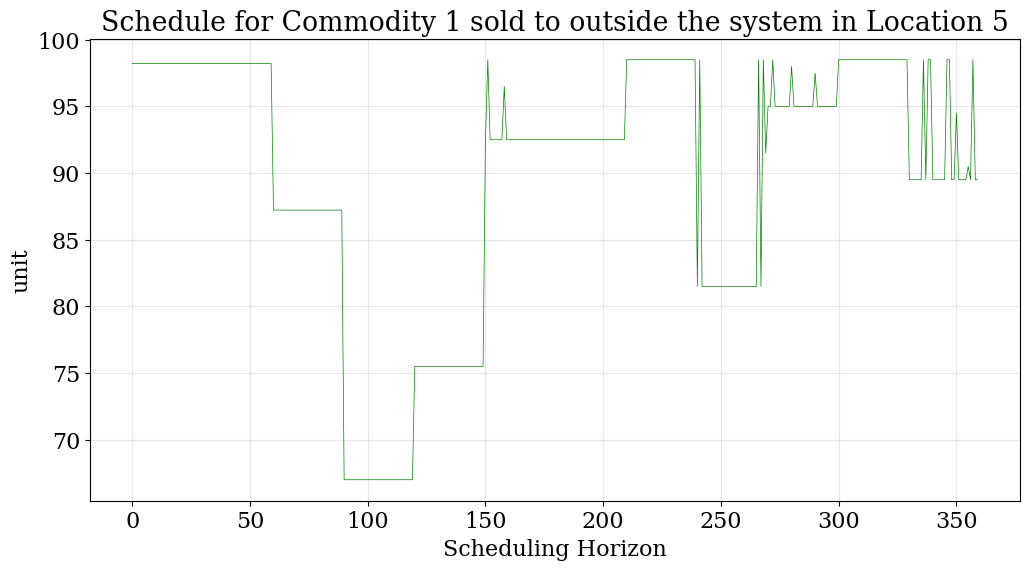

In [48]:
plot_results.schedule(results=results_mincost_6, y_axis='S', component='com1_sold', location='loc5', color='green')

In [49]:
min(value for key, value in results_mincost_6.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

67.0

In [50]:
# problem_mincost_7 = formulate(scenario=scenario_disruption,
#                               constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
#                                            Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND},
#                               demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_7 = 0.83
# min_demand_dict_7 = {i: {com1_sold: min_demand_satisfaction_7 * 100} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_7 = min_demand_dict_7
# if isinstance(min_demand_7, dict):
#     if isinstance(list(min_demand_7.keys())[0], Location):
#         try:
#             min_demand_7 = {i.name: {
#                 j.name: min_demand_7[i][j] for j in min_demand_7[i].keys()} for i in min_demand_7.keys()}
#         except:
#             pass
# 
# problem_mincost_7.del_component(constraint_demand2)
# problem_mincost_7.constraint_demand2 = constraint_demand2(instance=problem_mincost_7, demand=min_demand_7,
#                                                           demand_factor=scenario_disruption.demand_factor,
#                                                           demand_scale_level=scenario_disruption.demand_scale_level,
#                                                           scheduling_scale_level=scenario_disruption.scheduling_scale_level,
#                                                           cluster_wt=None, loc_res_dict=None, sign='geq')
# 
# results_mincost_7 = solve(scenario=scenario_disruption, instance=problem_mincost_7, solver='gurobi', name='MILP')

In [51]:
# plot_results.schedule(results=results_mincost_7, y_axis='S', component='com1_sold', location='loc5', color='green')

In [52]:
# min(value for key, value in results_mincost_7.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

In [53]:
# plot_results.cost(results=results_mincost, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc1')
# plot_results.cost(results=results_mincost_6, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc1')

In [54]:
# plot_results.cost(results=results_mincost, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc2')
# plot_results.cost(results=results_mincost_6, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc2')

In [55]:
# plot_results.cost(results=results_mincost, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc3')
# plot_results.cost(results=results_mincost_6, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc3')

In [56]:
# plot_results.cost(results=results_mincost, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc4')
# plot_results.cost(results=results_mincost_6, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc4')

In [57]:
# plot_results.cost(results=results_mincost, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc5')
# plot_results.cost(results=results_mincost_6, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc5')

In [58]:
# plot_results.cost(results=results_mincost, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc6')
# plot_results.cost(results=results_mincost_6, x=CostX.PROCESS_WISE, y=CostY.VOPEX, location='loc6')

In [59]:
# plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100_45', resource='com1_loc4_out')
# plot_results.transport(results=results_mincost_6, source='loc4', sink='loc5', transport='truck100_45', resource='com1_loc4_out')

In [60]:
# plot_results.schedule(results=results_mincost, y_axis='Inv', location='loc4', component='com1_stored50', color='green')
# plot_results.schedule(results=results_mincost_6, y_axis='Inv', location='loc4', component='com1_stored50', color='green')

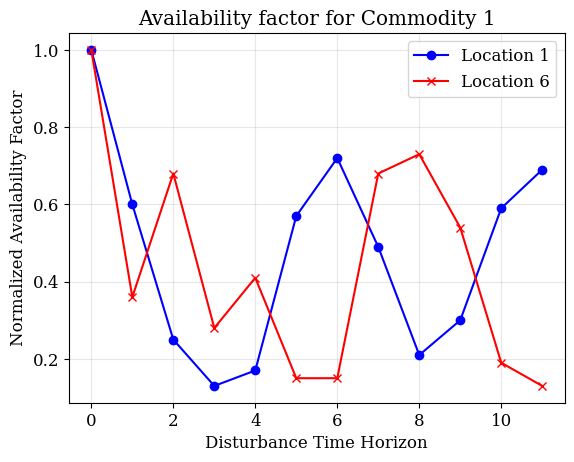

In [61]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(loc1_varying_factor['com1_pur']))), list(loc1_varying_factor['com1_pur']), label='Location 1', color='blue', marker='o')

ax.plot(range(len(list(loc6_varying_factor['com1_pur']))), list(loc6_varying_factor['com1_pur']), label='Location 6', color='red', marker='x')

# Customize the plot
ax.set_xlabel('Disturbance Time Horizon')
ax.set_ylabel('Normalized Availability Factor')
ax.set_title('Availability factor for Commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

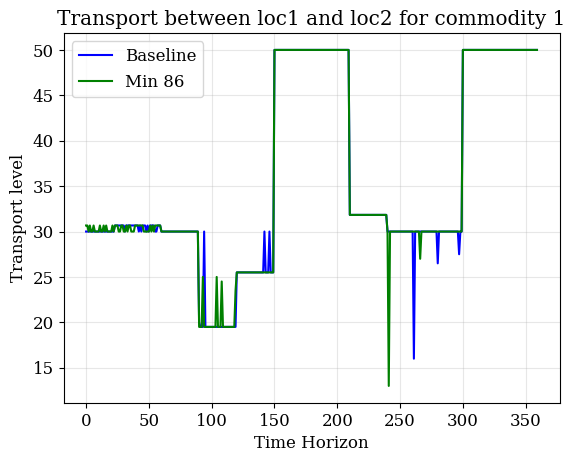

In [62]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc2 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

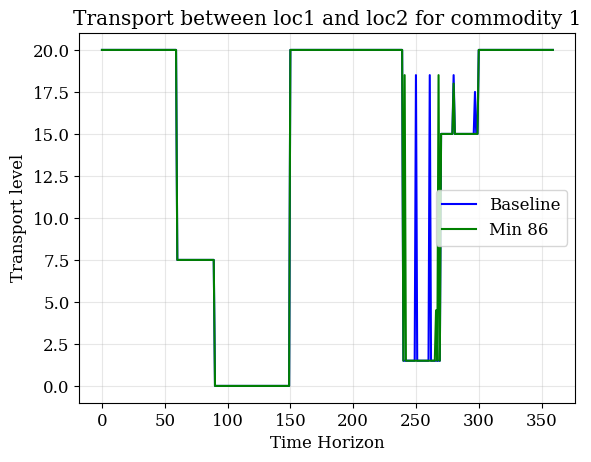

In [63]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc2 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

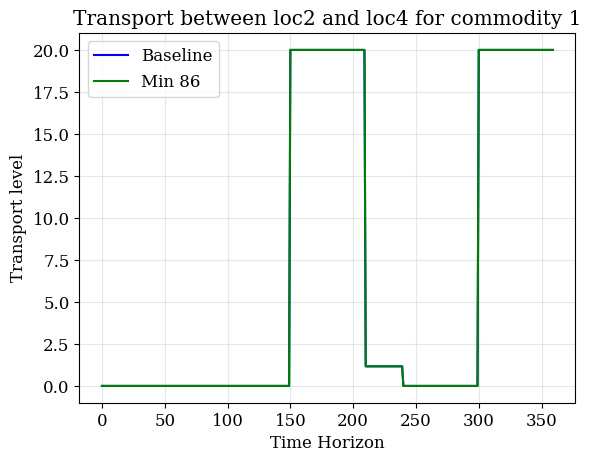

In [64]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

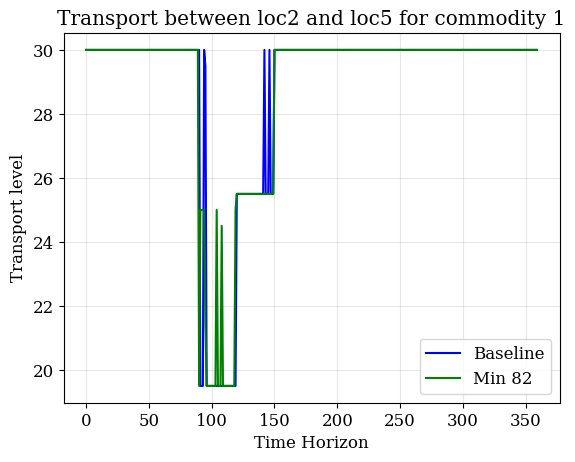

In [65]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'), label='Min 82', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

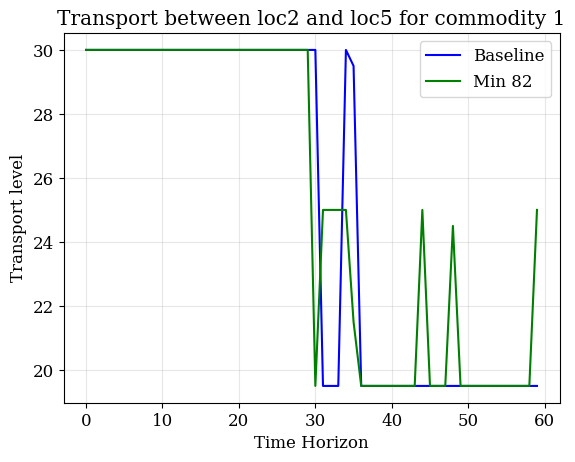

In [66]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out' and key[5]>=2 and key[5]<4))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out' and key[5]>=2 and key[5]<4), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out' and key[5]>=2 and key[5]<4))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out' and key[5]>=2 and key[5]<4), label='Min 82', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

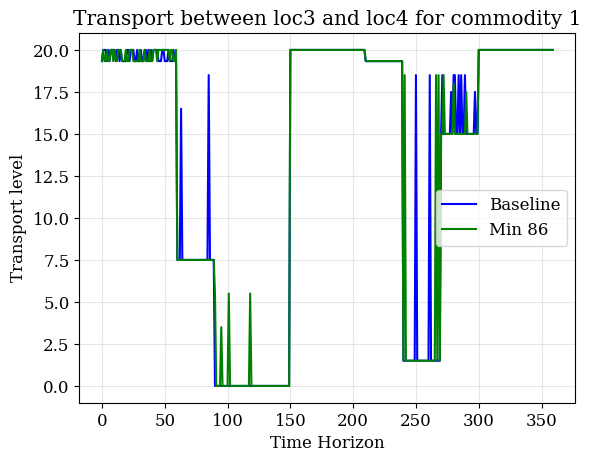

In [67]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc3 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

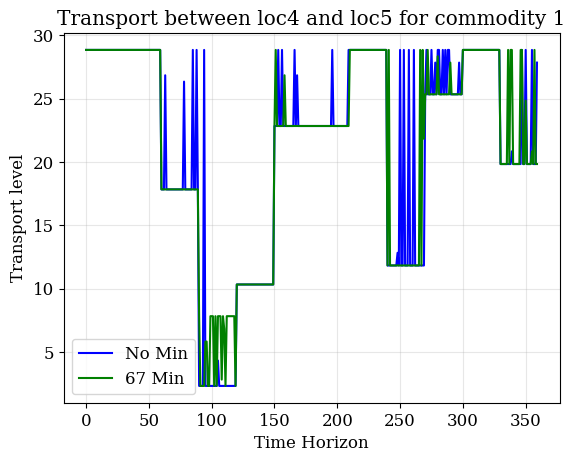

In [68]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'), label='67 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

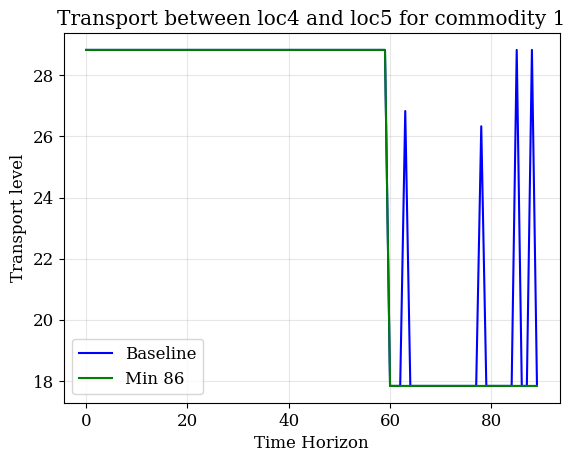

In [69]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out' and key[5]<=2))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'  and key[5]<=2), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out' and key[5]<=2))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out' and key[5]<=2), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

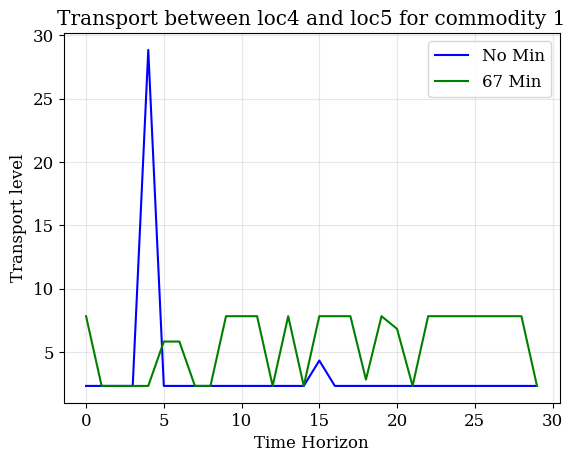

In [70]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out' and key[5]>2 and key[5]<4))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'  and key[5]>2 and key[5]<4), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out' and key[5]>2 and key[5]<4))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out' and key[5]>2 and key[5]<4), label='67 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

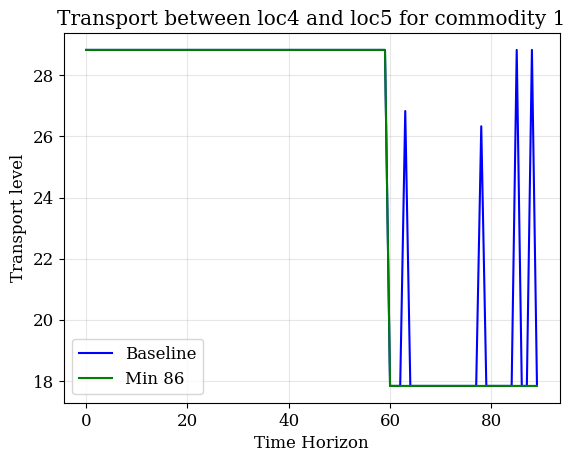

In [71]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out' and key[5]<=2))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'  and key[5]<=2), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out' and key[5]<=2))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out' and key[5]<=2), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

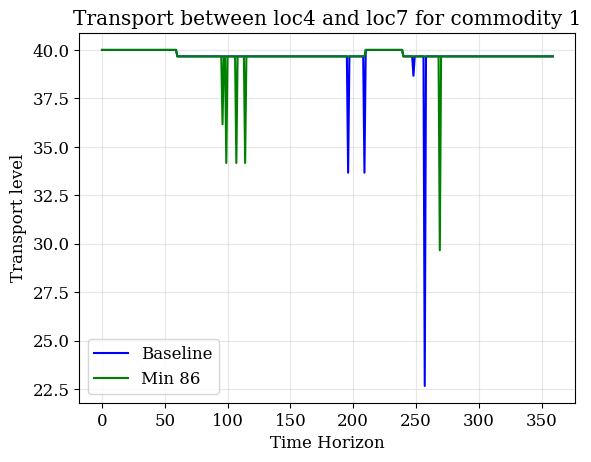

In [72]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc7 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

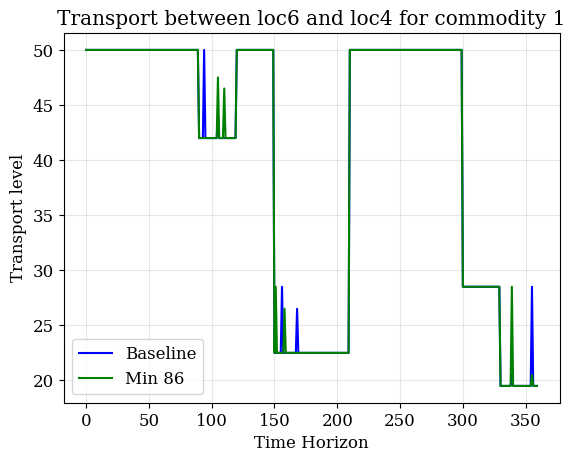

In [73]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc6 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

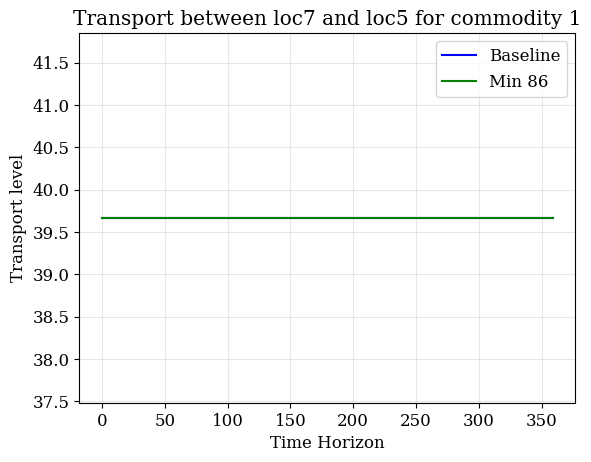

In [74]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost_6.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='Min 86', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc7 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

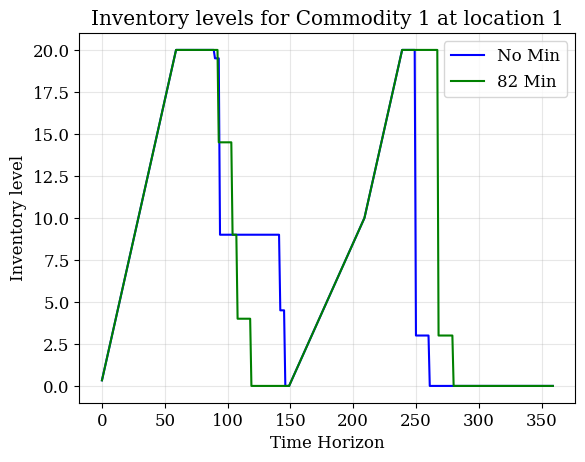

In [75]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

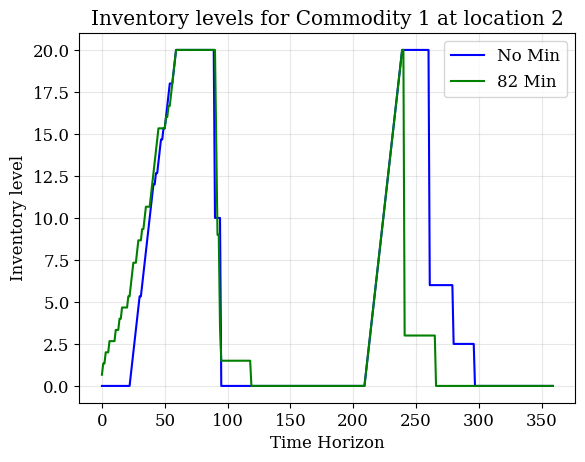

In [76]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 2')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

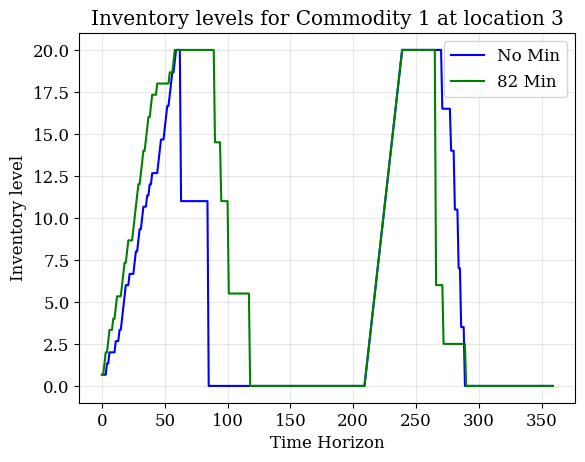

In [77]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 3')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

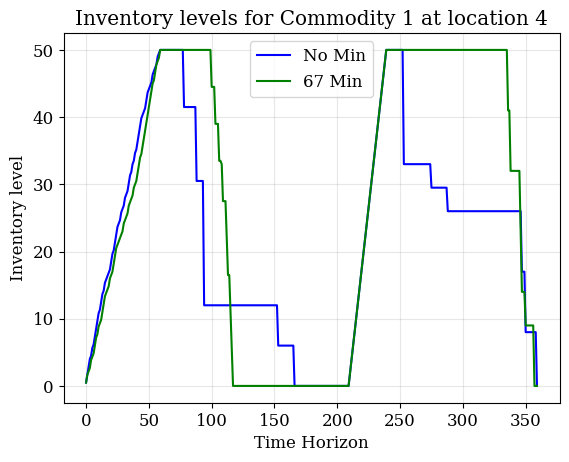

In [78]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_stored50'), label='67 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 4')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

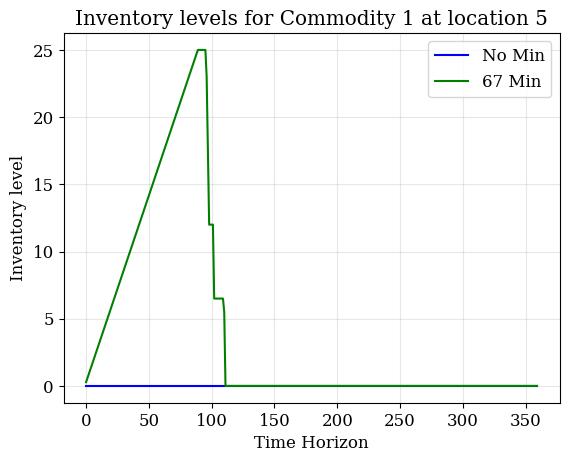

In [79]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'))), list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_stored50'), label='67 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 5')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

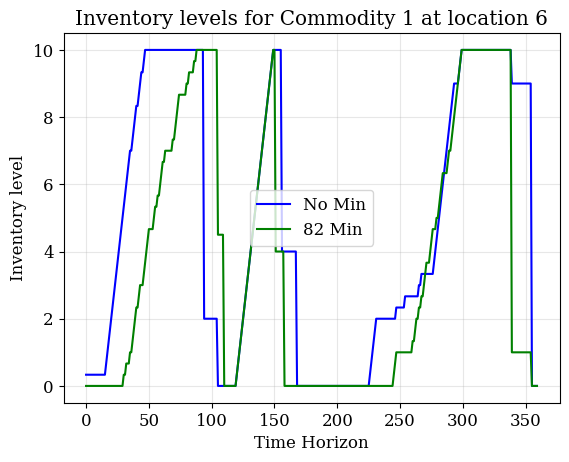

In [80]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'))), list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_stored10'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 6')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

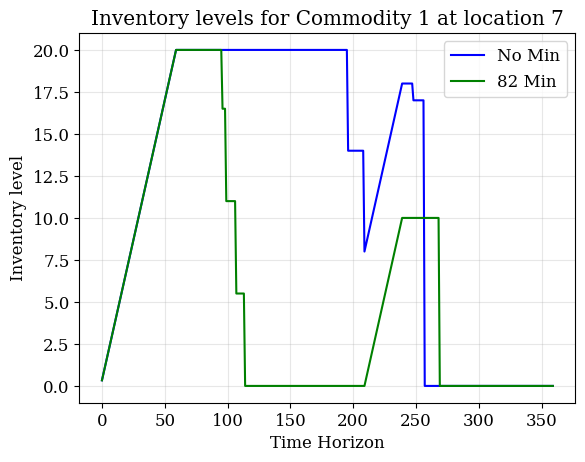

In [81]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'))), list(value for key, value in results_mincost_6.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_stored20'), label='82 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at location 7')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [82]:
results_mincost.output['objective']-sum(value for key, value in results_mincost.output['Demand_penalty'].items())*125

1912362.9666666659

In [83]:
results_mincost_6.output['objective']-sum(value for key, value in results_mincost_6.output['Demand_penalty'].items())*125

1912624.3555555567

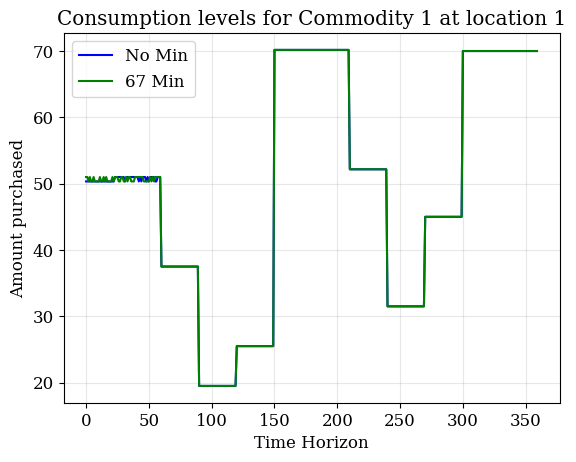

In [84]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['C'].items() if key[0]=='loc1' and key[1]=='com1_pur'))), list(value for key, value in results_mincost.output['C'].items() if key[0]=='loc1' and key[1]=='com1_pur'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['C'].items() if key[0]=='loc1' and key[1]=='com1_pur'))), list(value for key, value in results_mincost_6.output['C'].items() if key[0]=='loc1' and key[1]=='com1_pur'), label='67 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Amount purchased')
ax.set_title('Consumption levels for Commodity 1 at location 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

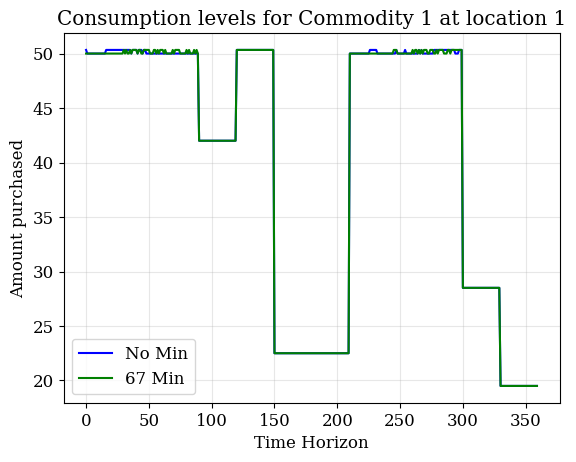

In [85]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['C'].items() if key[0]=='loc6' and key[1]=='com1_pur'))), list(value for key, value in results_mincost.output['C'].items() if key[0]=='loc6' and key[1]=='com1_pur'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_6.output['C'].items() if key[0]=='loc6' and key[1]=='com1_pur'))), list(value for key, value in results_mincost_6.output['C'].items() if key[0]=='loc6' and key[1]=='com1_pur'), label='67 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Amount purchased')
ax.set_title('Consumption levels for Commodity 1 at location 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [86]:
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')

3635.0

In [87]:
results_mincost.output['objective']-sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')*125

1912362.9666666659

In [88]:
sum(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/36000

0.8990277777777778

In [89]:
min(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

61.5

In [90]:
results_mincost_6.output['objective']-sum(value for key, value in results_mincost_6.output['Demand_penalty'].items() if key[0]=='loc5' and key[1]=='com1_sold')*125

1912624.3555555567

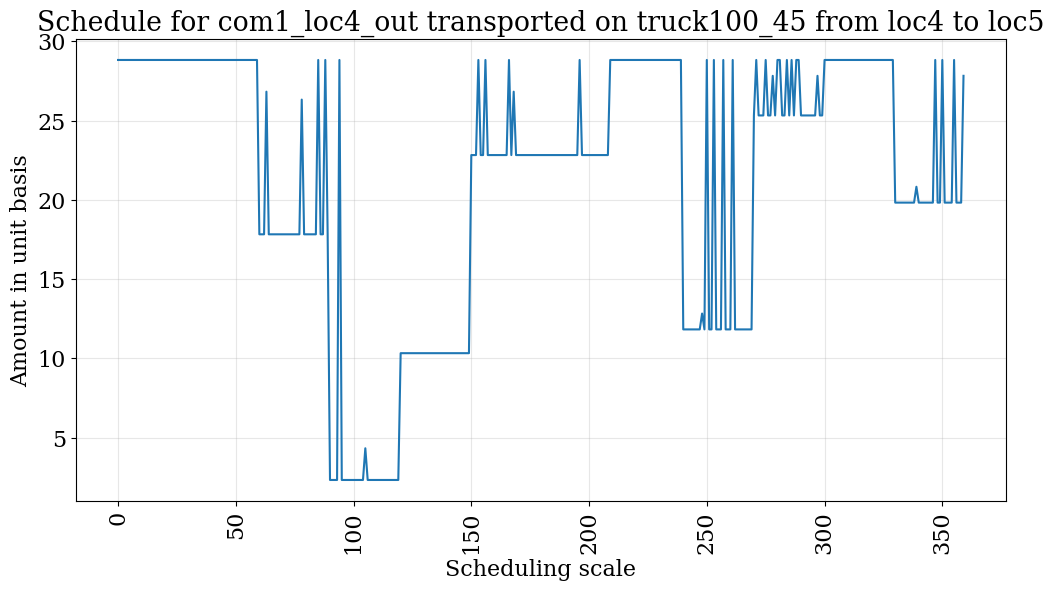

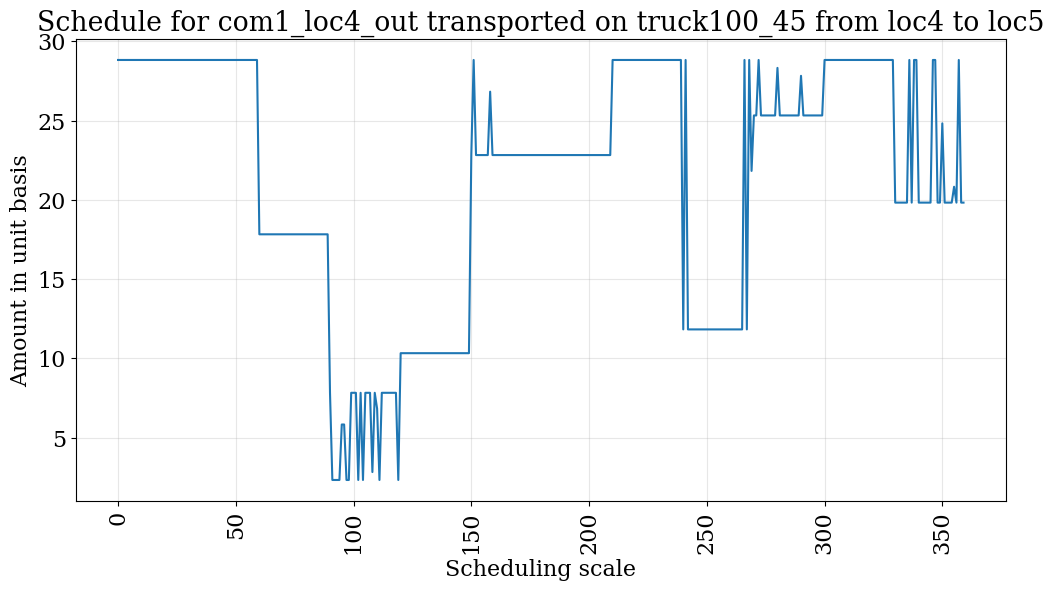

In [91]:
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100_45',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost_6, source='loc4', sink='loc5', transport='truck100_45',
                       resource='com1_loc4_out')

In [92]:
results_mincost.output['objective']

2366737.966666666

In [93]:
problem_mincost.Capex_network.pprint()

Capex_network : Capex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
      0 :     0 : 1237.966666666666 :  None : False :  True : NonNegativeReals


In [94]:
problem_mincost.Fopex_network.pprint()

Fopex_network : Fixed Opex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 121.30000000000001 :  None : False :  True : NonNegativeReals


In [95]:
problem_mincost.Vopex_network.pprint()

Vopex_network : Variable Opex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
      0 :     0 : 36432.99999999998 :  None : False :  True : NonNegativeReals


In [96]:
problem_mincost.Capex_transport_network.pprint()

Capex_transport_network : overall capex for transport at the network level
    Size=1, Index=scales_network
    Key : Lower : Value     : Upper : Fixed : Stale : Domain
      0 :     0 : 1463930.0 :  None : False :  True : NonNegativeReals


In [97]:
problem_mincost.Fopex_transport_network.pprint()

Fopex_transport_network : overall fopex for transport at the network level
    Size=1, Index=scales_network
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :     0 :   0.0 :  None : False :  True : NonNegativeReals


In [98]:
problem_mincost.Vopex_transport_network.pprint()

Vopex_transport_network : overall vopex for transport at the network level
    Size=1, Index=scales_network
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
      0 :     0 : 410640.6999999992 :  None : False :  True : NonNegativeReals


In [99]:
problem_mincost_6.Capex_network.pprint()
problem_mincost_6.Fopex_network.pprint()
problem_mincost_6.Vopex_network.pprint()
problem_mincost_6.Capex_transport_network.pprint()
problem_mincost_6.Fopex_transport_network.pprint()
problem_mincost_6.Vopex_transport_network.pprint()

Capex_network : Capex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 1376.8555555555558 :  None : False : False : NonNegativeReals
Fopex_network : Fixed Opex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :     0 : 121.3 :  None : False : False : NonNegativeReals
Vopex_network : Variable Opex at network scale
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 36555.499999999985 :  None : False : False : NonNegativeReals
Capex_transport_network : overall capex for transport at the network level
    Size=1, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 1463929.9999999998 :  None : False : False : NonNegativeReals
Fopex_transport_network : overall fopex for transport at the network level
    Size=1, In

In [100]:
results_mincost_6.output['objective']

2366999.3555555567

In [101]:
sum(value for key, value in results_mincost_6.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/36000

0.8990277777777783

In [102]:
sum(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/36000

0.8990277777777778

In [103]:
min(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

61.5

In [104]:
min(value for key, value in results_mincost_6.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

67.0